<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-Description" data-toc-modified-id="Data-Description-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data Description</a></span></li><li><span><a href="#Imports" data-toc-modified-id="Imports-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Useful-Scripts" data-toc-modified-id="Useful-Scripts-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Useful Scripts</a></span></li><li><span><a href="#Load-the-data" data-toc-modified-id="Load-the-data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Load the data</a></span></li><li><span><a href="#Train-test-split-with-stratify" data-toc-modified-id="Train-test-split-with-stratify-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Train test split with stratify</a></span></li><li><span><a href="#Classification:-isolationForest" data-toc-modified-id="Classification:-isolationForest-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Classification: isolationForest</a></span></li><li><span><a href="#Classification:-LOF-(Local-Outlier-Factor)" data-toc-modified-id="Classification:-LOF-(Local-Outlier-Factor)-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Classification: LOF (Local Outlier Factor)</a></span></li><li><span><a href="#Classification-Evaluation-Metrics" data-toc-modified-id="Classification-Evaluation-Metrics-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Classification Evaluation Metrics</a></span></li></ul></div>

# Data Description

The datasets contains transactions made by credit cards in September
2013 by european cardholders.


This dataset presents transactions that occurred in two days,
where we have 492 frauds out of 284,807 transactions. 

The dataset is highly unbalanced, the positive class (frauds)
account for 0.172% of all transactions.

It contains only numerical input variables which are
the result of a PCA transformation.


Unfortunately, due to confidentiality issues,
we cannot provide the original features and 
more background information about the data.


Features V1, V2, ... V28 are the principal
components obtained with PCA,
the only features which have not been transformed with PCA are 'Time' and 'Amount'. 

Feature 'Time' contains the seconds elapsed between each transaction
and the first transaction in the dataset. The feature 'Amount'
is the transaction Amount, this feature can be used for 
example-dependant cost-senstive learning. 

Feature 'Class' is the response variable and it takes value
1 in case of fraud and 0 otherwise.

# Imports

In [1]:
import bhishan

In [2]:
%load_ext autoreload

%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(color_codes=True)

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import os
import time

# random state
random_state=100
np.random.seed=random_state
np.random.set_state=random_state

# Jupyter notebook settings for pandas
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 100) # None for all the rows
pd.set_option('display.max_colwidth', 50)

print([(x.__name__,x.__version__) for x in [np, pd,sns,matplotlib]])

[('numpy', '1.16.4'), ('pandas', '0.25.0'), ('seaborn', '0.9.0'), ('matplotlib', '3.1.1')]


In [4]:
import scipy
from scipy import stats

In [5]:
# scale and split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

In [6]:
# classifiers
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

In [7]:
# roc auc etc scores
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score

In [8]:
# roc auc curves
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve

In [9]:
# confusion matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [10]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Useful Scripts

In [11]:
def show_method_attributes(method, ncols=7,exclude=None):
    """ Show all the attributes of a given method.
    Example:
    ========
    show_method_attributes(list)
     """
    x = [I for I in dir(method) if I[0]!='_' ]
    x = [I for I in x 
         if I not in 'os np pd sys time psycopg2'.split()
         if (exclude not in i)
        ]
             

    return pd.DataFrame(np.array_split(x,ncols)).T.fillna('')

In [12]:
df_eval = pd.DataFrame({'Model': [],
                        'Details':[],
                        'Accuracy':[],
                        'Precision':[],
                        'Recall':[],
                        'F1':[],
                        'Mathews Correlation Coefficient': [],
                        'Cohens Kappa': [],
                        'Area Under Precision Curve': [],
                        'Area Under ROC Curve': [],
                       })

def get_binary_classification_scalar_metrics(model_name,model,
                                             Xtest,ytest,ypreds,desc=''):
    """Get some binary classification evaluation metrics.
    
    Example:
    df_eval.loc[len(df_eval)] = get_binary_classification_scalar_metrics(
                       'Logistic Regression',clf_lr,Xtest,ytest,ypreds_lr)
    """
    
    # imports
    from sklearn.metrics import (accuracy_score,precision_score,
                                recall_score,f1_score,matthews_corrcoef,
                                average_precision_score,roc_auc_score,
                                cohen_kappa_score)
    
    # scalar metrics
    acc = accuracy_score(ytest,ypreds)
    precision = precision_score(ytest,ypreds)
    recall = recall_score(ytest,ypreds)
    f1 = f1_score(ytest,ypreds)
    mcc = matthews_corrcoef(ytest,ypreds)
    kappa = cohen_kappa_score(ytest, ypreds)
    
    # area under the curves
    try:
        y_score = model.predict_proba(Xtest)[:,1]
    except:
        y_score = model.decision_function(Xtest)
    
    auprc = average_precision_score(ytest, y_score)
    auroc = roc_auc_score(ytest, y_score)

    row = [model_name,desc,acc,precision,recall,f1,mcc,kappa,auprc,auroc]
    return row

In [13]:
df_clf_report = pd.DataFrame({'model':[],
                              'desc':[],
                              'precision_0': [],
                              'precision_1':[],
                              'recall_0':[],
                              'recall_1':[],
                              'f1_score_0':[],
                              'f1_score_1':[],
                              'support_0':[],
                              'support_1':[]})

def get_binary_classification_report(model_name,ytest,ypreds,desc=''):
    """Get binary classification report.
    
    Usage:
    -----
    row = get_binary_classification_report(model_name,ytest,ypreds)
    df_clf_report.loc[len(df_clf_report)] = row
    df_clf_report.drop_duplicates()
    """
    from sklearn.metrics import precision_recall_fscore_support

    row = [model_name,desc] + np.array(precision_recall_fscore_support(
                                    ytest,ypreds)).ravel().tolist()

    return row

In [14]:
def print_confusion_matrix(ytest,ypreds,model_name):
    """Print confusion matrix for binary classification.
    
    Example:
    print_confusion_matrix(ytest,ypreds_lr,'Logistic Regression')
    
    """
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(ytest,ypreds)
    total_correct = np.diag(cm).sum()
    total_wrong = cm.sum() - total_correct
    
    columns = ["Predicted Class " + str(class_name) for class_name in [0,1]]
    index = ["Class " + str(class_name) for class_name in [0,1]]
    

    df_confusion = pd.DataFrame(cm,columns=columns,index = index)
    df_confusion['Total Correct'] = total_correct
    df_confusion['Total Wrong'] = total_wrong
    
    df_style = df_confusion.style.set_caption(model_name).format("{:,.0f}")
    
    df_style = df_style.apply(lambda x: ["background: lightgreen" 
                                         if  v in np.diag(cm)
                                         else ""
                                         for v in x], axis = 1)
    
    df_style = df_style.apply(lambda x: ["background: salmon" 
                                         if  ( v in cm and v not in np.diag(cm))
                                         else ""
                                         for v in x], axis = 1)

    return df_style

# Load the data

In [15]:
df = pd.read_csv('../data/raw/creditcard.csv.zip',compression='zip')
print(df.shape)
df.head()

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# Train test split with stratify

In [16]:
from sklearn.model_selection import train_test_split

target = 'Class'
Xtrain, Xtest, ytrain, ytest = train_test_split(
    df.drop(target,axis=1), df[target],
    test_size=0.2, random_state=random_state, stratify=df[target])

df.shape, Xtrain.shape, Xtest.shape

((284807, 31), (227845, 30), (56962, 30))

In [17]:
outlier_fraction = ytrain[ytrain==1].shape[0] /   ytrain[ytrain==0].shape[0]

# Classification: isolationForest

Reference:   
scikit learn  
https://scikit-learn.org/stable/modules/outlier_detection.html

One efficient way of performing outlier detection in high-dimensional datasets is to use random forests. The ensemble.IsolationForest ‘isolates’ observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature.

Since recursive partitioning can be represented by a tree structure, the number of splittings required to isolate a sample is equivalent to the path length from the root node to the terminating node.

This path length, averaged over a forest of such random trees, is a measure of normality and our decision function.

Random partitioning produces noticeably shorter paths for anomalies. Hence, when a forest of random trees collectively produce shorter path lengths for particular samples, they are highly likely to be anomalies.

The implementation of ensemble.IsolationForest is based on an ensemble of tree.ExtraTreeRegressor. Following Isolation Forest original paper, the maximum depth of each tree is set to  where  is the number of samples used to build the tree (see (Liu et al., 2008) for more details).

This algorithm is illustrated below.
![](../images/isolation_forest_sklearn.png)

In [18]:
%%time

clf_iso = IsolationForest(n_estimators=100,
                      max_samples=len(Xtrain),
                      n_jobs=-1,
                      contamination=outlier_fraction,
                      random_state=random_state,
                      verbose=1,
                      behaviour='new')


# fitting  
clf_iso.fit(Xtrain)

# prediction
scores_prediction = clf_iso.decision_function(Xtest)
ypreds = clf_iso.predict(Xtest)

# algorithm gives 1 and -1 classes, make them 0 and 1
ypreds[ypreds == 1] = 0
ypreds[ypreds == -1] = 1

ypreds_iso = ypreds

print(classification_report(ytest, ypreds_iso))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    4.2s remaining:    4.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    4.3s finished


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.25      0.26      0.25        98

    accuracy                           1.00     56962
   macro avg       0.62      0.63      0.62     56962
weighted avg       1.00      1.00      1.00     56962

CPU times: user 24.6 s, sys: 2.49 s, total: 27.1 s
Wall time: 20.3 s


# Classification: LOF (Local Outlier Factor)

Reference: sklearn  

Unsupervised Outlier Detection using Local Outlier Factor (LOF)

The anomaly score of each sample is called Local Outlier Factor. It measures the local deviation of density of a given sample with respect to its neighbors. It is local in that the anomaly score depends on how isolated the object is with respect to the surrounding neighborhood. More precisely, locality is given by k-nearest neighbors, whose distance is used to estimate the local density. By comparing the local density of a sample to the local densities of its neighbors, one can identify samples that have a substantially lower density than their neighbors. These are considered outliers.

In [19]:
%%time

clf_lof = LocalOutlierFactor(n_neighbors=20,
                      algorithm='auto', 
                      leaf_size=30,
                      metric='minkowski',
                      p=2,
                      n_jobs=-1,
                      metric_params=None,
                      novelty=True,
                      contamination=outlier_fraction)



clf_lof.fit(Xtrain)
ypreds = clf_lof.predict(Xtest)

# alogrithm gives 1 and -1 classes, make them 0 and 1
ypreds[ypreds == 1] = 0
ypreds[ypreds == -1] = 1

ypreds_lof = ypreds

print(classification_report(ytest, ypreds_lof))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.03      0.03      0.03        98

    accuracy                           1.00     56962
   macro avg       0.51      0.51      0.51     56962
weighted avg       1.00      1.00      1.00     56962

CPU times: user 11.5 s, sys: 304 ms, total: 11.8 s
Wall time: 7.59 s


# Classification Evaluation Metrics
![](../images/classification_metrics.png)
![](../images/confusion_matrix.png)
![](../images/accuracy.png)
![](../images/precision.png)
![](../images/recall.png)
![](../images/f1_score.png)

In [20]:
# ! for filename in ../images/*.png; do echo '!'"[]($filename)"; done

In [21]:
from sklearn.metrics import (accuracy_score,precision_score,
                                recall_score,f1_score,matthews_corrcoef,
                                average_precision_score,roc_auc_score,
                                cohen_kappa_score)
   

In [22]:
# scalar metrics
ypreds = ypreds_iso
acc = accuracy_score(ytest,ypreds)
precision = precision_score(ytest,ypreds)
recall = recall_score(ytest,ypreds)
f1 = f1_score(ytest,ypreds)
mcc = matthews_corrcoef(ytest,ypreds)
kappa = cohen_kappa_score(ytest, ypreds)

print(acc,precision,recall,f1,mcc,kappa)

0.9973666654962958 0.24509803921568626 0.25510204081632654 0.25 0.24873147208089602 0.24868154572013246


In [23]:
# area under the curves
try:
    y_score = clf_iso.predict_proba(Xtest)[:,1]
except:
    y_score = clf_iso.decision_function(Xtest)

auprc = average_precision_score(ytest, y_score)
auroc = roc_auc_score(ytest, y_score)

print(auprc, auroc)

0.0008812221863141853 0.054973269555430505


In [24]:
df_eval.loc[len(df_eval)] = get_binary_classification_scalar_metrics('Isolation Forest',clf_iso,Xtest,ytest,ypreds_iso)

df_eval.loc[len(df_eval)] = get_binary_classification_scalar_metrics('Local Outlier Factor',clf_lof,Xtest,ytest,ypreds_lof)
df_eval.drop_duplicates()

,Model,Details,Accuracy,Precision,Recall,F1,Mathews Correlation Coefficient,Cohens Kappa,Area Under Precision Curve,Area Under ROC Curve
0,Isolation Forest,,0.997367,0.245098,0.255102,0.250000,0.248731,0.248682,0.000881,0.054973
1,Local Outlier Factor,,0.996331,0.025641,0.030612,0.027907,0.026186,0.026083,0.001050,0.253340


In [25]:
row = get_binary_classification_report('Isolation Forest',ytest,ypreds_iso)
df_clf_report.loc[len(df_clf_report)] = row



row = get_binary_classification_report('Local Outlier Factor',ytest,ypreds_lof)
df_clf_report.loc[len(df_clf_report)] = row

df_clf_report.drop_duplicates()

,model,desc,precision_0,precision_1,recall_0,recall_1,f1_score_0,f1_score_1,support_0,support_1
0,Isolation Forest,,0.998716,0.245098,0.998646,0.255102,0.998681,0.250000,56864.0,98.0
1,Local Outlier Factor,,0.998329,0.025641,0.997995,0.030612,0.998162,0.027907,56864.0,98.0


In [26]:
print(classification_report(ytest,ypreds_iso))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.25      0.26      0.25        98

    accuracy                           1.00     56962
   macro avg       0.62      0.63      0.62     56962
weighted avg       1.00      1.00      1.00     56962



In [27]:
print_confusion_matrix(ytest,ypreds_iso,'Isolation Forest')

,Predicted Class 0,Predicted Class 1,Total Correct,Total Wrong
Class 0,"56,787",77,"56,812",150
Class 1,73,25,"56,812",150


In [28]:
print_confusion_matrix(ytest,ypreds_lof,'Local Outlier Factor')

,Predicted Class 0,Predicted Class 1,Total Correct,Total Wrong
Class 0,"56,750",114,"56,753",209
Class 1,95,3,"56,753",209


In [29]:
cm = confusion_matrix(ytest,ypreds)

In [30]:
cm

array([[56787,    77],
       [   73,    25]])

(2.0, 0.0)

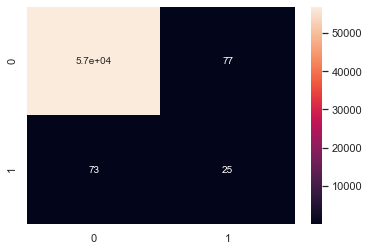

In [31]:
ax = sns.heatmap(cm, annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

In [32]:
from bhishan.util_plot_model_eval import plotly_binary_clf_evaluation

yscore_iso = clf_iso.decision_function(Xtest)

ofile = '../reports/html/isolation_forest_model_evaluation.html'
plotly_binary_clf_evaluation('clf_iso',clf_iso,ytest,ypreds_iso,yscore_iso,df,ofile=ofile,show=False)

plotly_binary_clf_evaluation('clf_iso',clf_iso,ytest,ypreds_iso,yscore_iso,df,show=True)